<a href="https://colab.research.google.com/github/sayan0506/Classify-Geometric-Images/blob/main/Deep_Learning_for_Geometric_Images_Classification_Keras_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning for Geometric Images Classification Keras implementation**

The task here is is to build a classifier that can classify for a given image as one of the 4 geometric data categories present in the dataset.  In order to train or test, we can consider all four categories with different orientations for training and inference. Detailed problem statement can be found [here](https://drive.google.com/drive/folders/12QAMwLlb_XglBFlvw7Q-CI1nNmMQW-D0?usp=sharing)

**Install Dependencies**

In [1]:
# install wandb
!pip install wandb

# install keras livelossplot
!pip install livelossplot

# insatll imgaug lib
!pip install --upgrade imgaug
!pip install imagecorruptions

     |████████████████████████████████| 1.8MB 12.0MB/s 
     |████████████████████████████████| 133kB 48.8MB/s 
     |████████████████████████████████| 102kB 13.1MB/s 
     |████████████████████████████████| 174kB 32.9MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=9ab03c75b4eda70f6558a8271116b2ce1e504a0dafd69312815344974003cb05
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=fb8d828e37901f26352543ebf4cd71291dd7163f8631214735ffcf41474b4d36
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32
     |████████████████████████████████| 952kB 8.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.

## **Import Dependencies**

Importing necessary python modules

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import pandas as pd
import seaborn as sns
import random
from easydict import EasyDict as edict
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2
import tensorflow as tf
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

import keras
from livelossplot import PlotLossesKeras
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json

from sklearn import metrics
from sklearn.metrics import confusion_matrix 
import matplotlib.cm as cm

from google.colab import files

## **Mount Drive**

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


## **Environment Setup**

**Improve Reproducibility**

In [4]:
# improve reproducibility and make it more deterministic
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity")% 2**32 -1)

**GPU utilization**

In [5]:
# System Setup
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10791351941545304673, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14807483493924347529
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [6]:
# Checking GPU utilization
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found!')

print(f'Found GPU at: {device}')

Found GPU at: /device:GPU:0


**Change currebt working directory to "/content/"**

In [7]:
%cd /content/

/content


**Setup wandb environment for trainining logs**

In [8]:
# import wandb dependencies
import wandb
from wandb.keras import WandbCallback

In [ ]:
# authorize
wandb.login()

## **Dataset Load**

The dataset comprises of images of different geometries categorized into 4 classes. We need to perform image classification on it.

**Shared dataset(accessed through mounted drive) link - [images_2 dataset](https://drive.google.com/drive/folders/1DiVHn-Yg_asQwjp2YvhTjzN57Wbkaszl?usp=sharing)**


In [10]:
# dataset path
dataset_path = '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset'

print('Dataset Content\n')
# explore the content of dataset
os.chdir(dataset_path)
!ls

Dataset Content

test  train


## **Data Inspection & Data Preparation**

Corresponding to each identity 4 different class samples available which corresponds to

1. Category 1
2. Category 2[link text](https://)
3. Category 3
4. Category 4

**Defining configuration dictionary, which will contain important metadata regarding the ML pipeline**

In [20]:
# config edict initialize
config = edict()

In [21]:
# configure device
config.device = device

**Classifiers list**


In [23]:
# train folder path
folder_path = '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/train'

# class list present in the folders
class_list = [classifier for classifier in os.listdir(folder_path) if classifier!='.DS_Store']
print(f'Geometric class categories in the dataset\n{class_list}')

Geometric class categories in the dataset
['category 4', 'category 3', 'category 2', 'category 1']


In [24]:
# Geometric data Classifiers in the following defined order 
classifiers = ['category 1', 'category 2', 'category 3', 'category 4']
# configure classifiers list
config.classifiers = classifiers

**Function for image to array conversion using keras**

In [25]:
def convert_img_to_array(image_path):
  try:
    img = plt.imread(image_path)
    if img is not None:
      return img_to_array(img)
    else:
      return np.array([])
  
  except Exception as e:
    print(f'Error {e}')
    return None

**Analyze category-wise samples available count**

In [26]:
def fetch_img(img_dir):
  classifiers_path = [os.path.join(img_dir, classifier) for classifier in config.classifiers]
  print(f'Geometric directory names list {classifiers_path}')
  # image array list
  image_list = []
  # image labels list
  label_list = []
  # label_dataframe
  label_df = pd.DataFrame(columns=config.classifiers)
  # image dataframe
  img_df = pd.DataFrame(columns=['Image', 'Shape', 'Label'])

  try:
    print('\n[INFO] Loading images ...')
    # total sample count
    sample_count = 0
    for sr, category_path in enumerate(classifiers_path):
      print(f'[INFO] Processing {config.classifiers[sr]}')
      sample_list = os.listdir(category_path)
      #print(len(sample_list))
      for category_sample in sample_list:
        # removing the .DS_store files from list, which contains the folder infos
        if category_sample == '.DS_store':
          sample_list.remove(category_sample)
      # categorical count
      count = 0
      for category_sample in sample_list:
        category_sample_path = os.path.join(category_path, category_sample)
        if category_sample_path.endswith(".png") == True or category_sample_path.endswith(".PNG") == True:
          img = convert_img_to_array(category_sample_path)
          img_df.loc[sample_count,'Image'], img_df.loc[sample_count,'Label'] = category_sample, config.classifiers[sr]
          img_df.loc[sample_count,'Shape'] = img.shape
          count += 1
          sample_count += 1
      label_df.loc[0, config.classifiers[sr]] = count

    return label_df, img_df   
      
  except Exception as e:
    print(f'Error {e}')
    return None

#### **Fetching geometric images path for 4 classes for train dataset and prepare dataframes**

In [27]:
# train image directory
img_dir_train = "/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/train"

print(f'Image directory {img_dir_train}\n')

# fetching label_array, image_array
label_df_train, img_df_train = fetch_img(img_dir_train)

# config target distribution
config.distribution = label_df_train

print(f'Category wise counts in train dataset\n{label_df_train}')
img_df_train

Image directory /content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/train

Geometric directory names list ['/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/train/category 1', '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/train/category 2', '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/train/category 3', '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/train/category 4']

[INFO] Loading images ...
[INFO] Processing category 1
[INFO] Processing category 2
[INFO] Processing category 3
[INFO] Processing category 4
Category wise counts in train dataset
  category 1 category 2 category 3 category 4
0        102        107        112        119


Image  ...       Label
0    category 1_original_1040.png_09feef9b-7d51-415...  ...  category 1
1    category 1_original_1041.png_fa7ef29f-cf78-4ee...  ...  category 1
2    category 1_original_1040.png_908f3c74-eed6-479...  ...  category 1
3    category 1_original_1012.png_e217e460-81e5-408...  ...  category 1
4    category 1_original_1031.png_921efb1a-23c6-44c...  ...  category 1
..                                                 ...  ...         ...
435  category 4_original_C030.png_8a5e02ba-8431-48e...  ...  category 4
436  category 4_original_C041.png_6dc9e80b-f6f3-437...  ...  category 4
437  category 4_original_C024.png_e3fbf0ea-d214-4f5...  ...  category 4
438  category 4_original_C000.png_5fde89c2-1349-424...  ...  category 4
439  category 4_original_C040.png_46defe44-d6f3-468...  ...  category 4

[440 rows x 3 columns]

**Target Distribution Visualize for Train set**

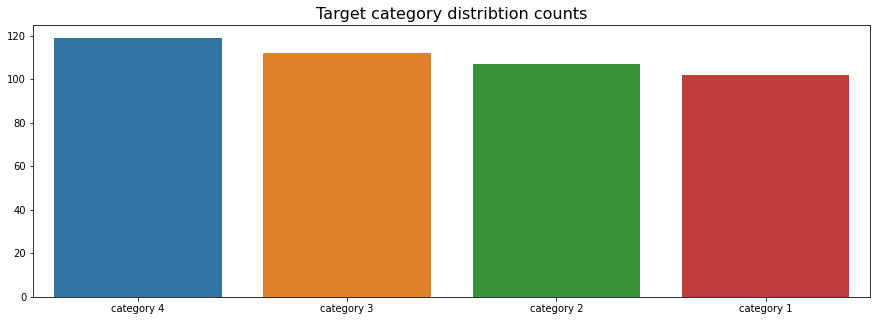

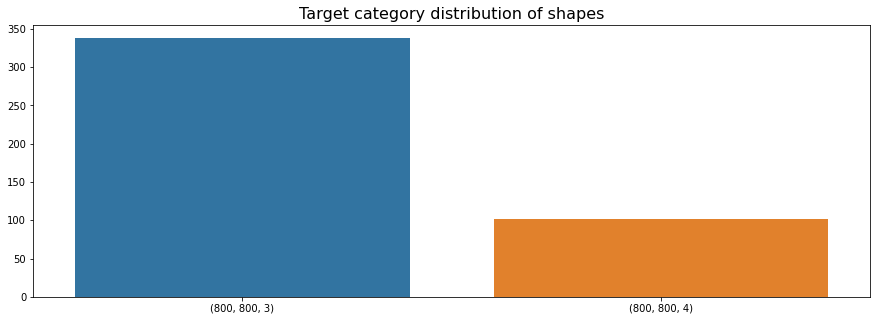

In [28]:
def distribution_vis(counts_series, label):
  '''
  Target distribution
  '''
  fig = plt.figure(figsize = (15,5))
  sns.barplot(x = counts_series.index, y = counts_series.values)
  plt.title(label, fontsize = 16)

# returns pandas series with classes as keys and count as values for train dataset
target_counts_train = img_df_train['Label'].value_counts()

# shape analysis for train
shape_counts_train = img_df_train['Shape'].value_counts()

# visualize target distribution for labels
distribution_vis(target_counts_train, label = 'Target category distribtion counts')

# visualize shapes distribution for image shapes
distribution_vis(shape_counts_train, label = 'Target category distribution of shapes')

* The data corresonding to 4 categories are imbalanced**
* Some of images are of 4 channels having all images of resolutions (800,800)

**Train Image category-wise Shapes EDA**

Image shape comparison between different categories 

Shape          Label     
(800, 800, 3)  category 4    119
               category 3    112
               category 2    107
(800, 800, 4)  category 1    102
dtype: int64



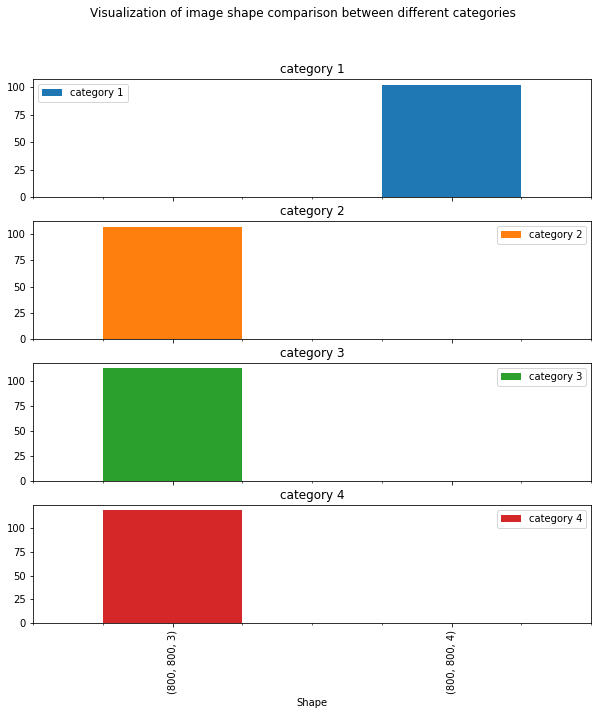

In [29]:
level_shape_df = img_df_train[['Shape', 'Label']].value_counts()
print(f'Image shape comparison between different categories \n\n{level_shape_df}\n')

# plotting the multi-index dataframe's hist() plot, where label, and shape are two index
level_shape_df.unstack(level = 1).plot(kind = 'bar', subplots = True, figsize = (10,10), 
                                       title = 'Visualization of image shape comparison between different categories')
plt.show()

**We found here that all images corresponding to category 1 are of 4 channels**

#### **Experiment on 4 channel to 3 channel image conversion**

Function to rescale images

In [30]:
def img_rescale(img_path):
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  # in case grayscale image len(img.shape) == 2  
  if len(img.shape)>2 and img.shape[2]==4:
    # convert the image from RGBA2RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
  # convert BGR to RGB
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # convert to float32
  img = img.astype(np.float32)

  return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


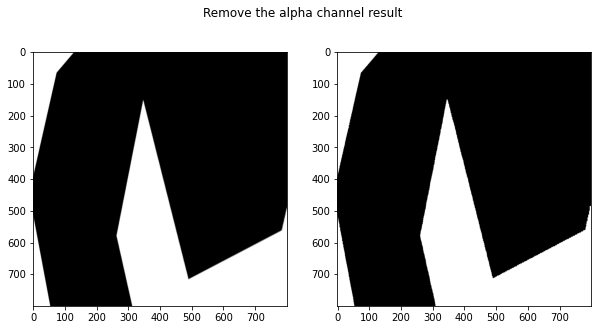

Image dtype before, after removal float32, float32
Image shape before, after removal (800, 800, 4), (800, 800, 3)


In [33]:
# take sample image of category 1
sample_img_path = '/content/drive/MyDrive/Geometric image classification/Geometric Image Classification/Image_2/Input/Dataset/train/category 1/category 1_original_1000.png_01b3b4fc-dabe-457d-9159-3c2e7eb77785.png'

fig = plt.figure(figsize=(10,5))
fig.suptitle('Remove the alpha channel result')

# original image
img = plt.imread(sample_img_path)
fig.add_subplot(121)
plt.imshow(img)

# after removing alpha channel
img_rgb = img_rescale(sample_img_path)
fig.add_subplot(122)
plt.imshow(img_rgb)

plt.show()

print(f'Image dtype before, after removal {img.dtype}, {img_rgb.dtype}')
print(f'Image shape before, after removal {img.shape}, {img_rgb.shape}')

#### **Removing alpha cannel from images of category 1**

In [ ]:
category1_path = 


**Saving the fetched train image info to train.csv**

In [71]:
%cd /content/
# save to train csv
img_df_train.to_csv('train.csv')

# config img_df
config.img_df = img_df_train

/content


#### **Train-Validation-Test Split**

We are taking train, valid, test ratio as - [0.95:0.05]

In [64]:
# validation split
val_ratio = 0.05
# test split
#test_ratio = 0.5

# image_ids
img_ids = img_df_train.loc[:,'Image']

# image_ids
label_ids = img_df_train.loc[:,'Label']

**Defining train, validation dataframe**

In [65]:
# train df
train_df = pd.DataFrame(columns=['Image','Label'])
# validation main df
#valid_main_df = pd.DataFrame(columns=['Image','Label'])
# validation df
valid_df = pd.DataFrame(columns=['Image','Label'])
# test df
#test_df = pd.DataFrame(columns=['Image','Label'])

**Defining Train, Valid, Test split**

Train-Valid_main split

In [66]:
# without shuffling startification is not possible
train_df['Image'], valid_df['Image'], train_df['Label'], valid_df['Label'] = train_test_split(img_ids, label_ids,
                                                                                                        test_size = val_ratio,
                                                                                                        random_state = 28,
                                                                                                        stratify = label_ids,
                                                                                                        shuffle = True
                                                                                                        )

In [67]:
print(f'Train dataframe shape {train_df.shape}')
print(f'Validation dataframe shape {valid_df.shape}')

Train dataframe shape (418, 2)
Validation dataframe shape (22, 2)


**Startification Check**

Defining visualization function for stratified train valid split

In [68]:
# startified vis func
def distribution_vis_check(train, valid):
  '''
  Target distribution
  '''
  xdf = [train.index, valid.index]
  ydf = [train.values, valid.values]
  label = ['Train Distribution', 'Validation Distribution']
  fig = plt.figure(figsize=(20,5))
  for i in range(len(xdf)):
    fig.add_subplot(1, len(xdf), i+1)
    sns.barplot(x = xdf[i], y = ydf[i])
    plt.xlabel(label[i], fontsize = 16)

**Stratification result**

In [69]:
print('Startification result-')
print('Train set -\n{}'.format(train_df['Label'].value_counts()))
print('Validation set -\n{}'.format(valid_df['Label'].value_counts()))

Startification result-
Train set -
category 4    113
category 3    106
category 2    102
category 1     97
Name: Label, dtype: int64
Validation set -
category 3    6
category 4    6
category 2    5
category 1    5
Name: Label, dtype: int64


**Startification Distribution Visualize**

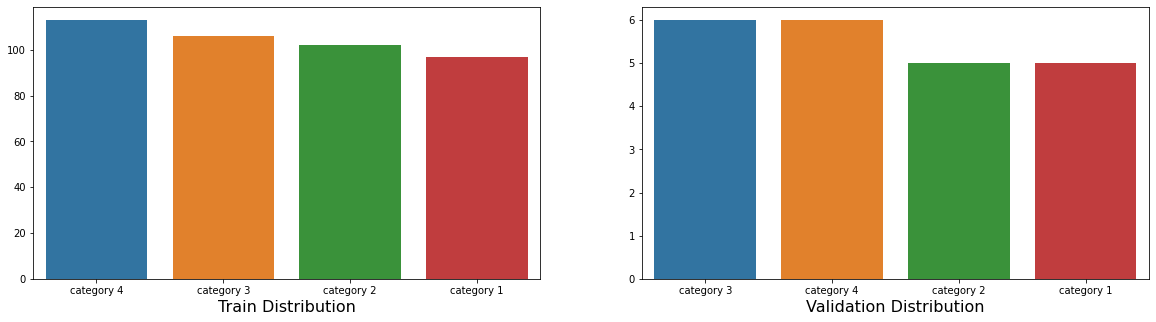

In [70]:
distribution_vis_check(train_df['Label'].value_counts(), valid_df['Label'].value_counts())

The data is stratified split almost

#### **Define Image Pre-processing function**

It converts the input infrared image to opencv jet colormap and returns as RGB numpy array of datatype float32

In [ ]:
def img_preprocess(path):
  # read the infrared image from the given path in unchanged mode
  img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

  # convert from BGR to RGB format
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  # convert to float32
  #img = img.astype(np.float32)
  
  # convert to jet colormap by converting to uint8 default format that is acceted by opencv 4.5.2
  img = cv2.applyColorMap((img).astype('uint8'), cv2.COLORMAP_JET)
   
  #img = cv2.normalize(img, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = np.float32)
  # convert to float32
  img = img.astype(np.float32)
  
  # reshape images to (256,256) using keras with 'Bicubic Interpolation
  img = tf.keras.preprocessing.image.smart_resize(img, size=(256,256), interpolation='bicubic')
  
  # normalize the image, as due to interpolation the pixel value may not lie in the range (0,255)
  # to restrict that we neeed to normalize them so than it can lie within a scale 
  img -= img.min()
  img /= (img.max() - img.min()) 

  return img

**Check conversion**

Demo image shape (256, 256, 3)
Demo image datatype float32
Max, min pixel values 0.0, 1.0


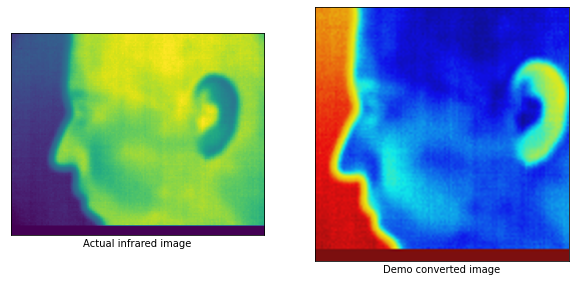

In [ ]:
# sample image path
demo_img_path = '/content/drive/MyDrive/DeepLearning_Assignment_Drunk_Sober_Classify/01_petros/01_petros_3_r_M_20_71_032.tif'
demo_img = img_preprocess(demo_img_path)
print(f'Demo image shape {demo_img.shape}')
print(f'Demo image datatype {demo_img.dtype}')
print(f'Max, min pixel values {demo_img.min()}, {demo_img.max()}')
fig = plt.figure(figsize = (10,5))
fig.add_subplot(121)
plt.imshow(cv2.imread(demo_img_path, cv2.IMREAD_UNCHANGED))
plt.xlabel('Actual infrared image')
plt.xticks([])
plt.yticks([])
fig.add_subplot(122)
plt.imshow(demo_img)
plt.xlabel('Demo converted image')
plt.xticks([])
plt.yticks([])

plt.show()

**Visualize sample images of a person**

Demo of single person images named 29_lia
Each of 2nd row is the actual image, and 1st row is the colomap trnsformed image!
Person 29_lia


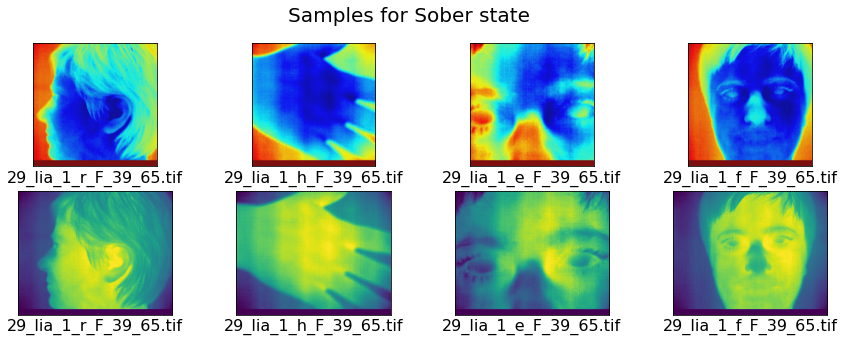

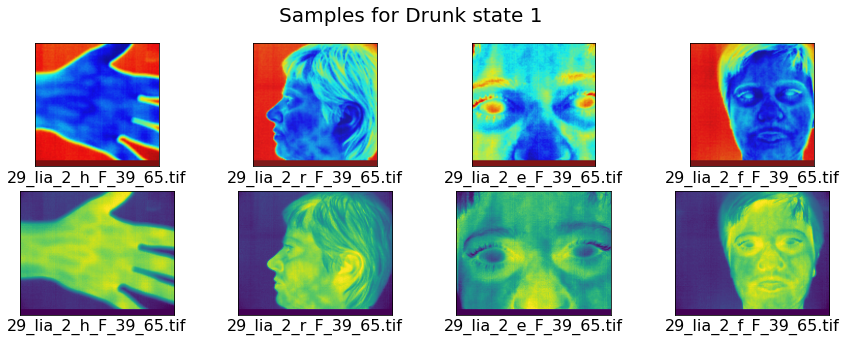

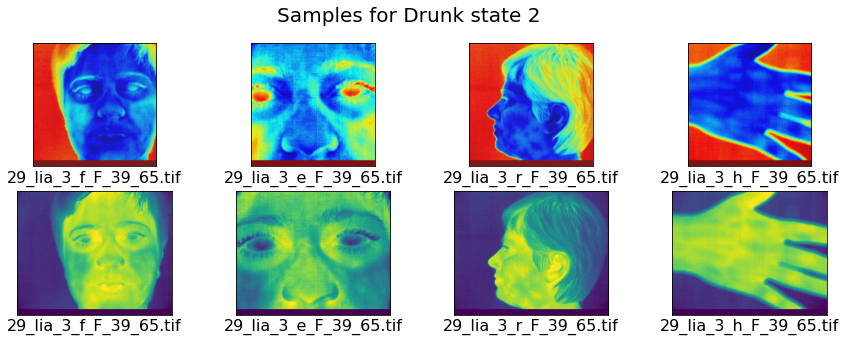

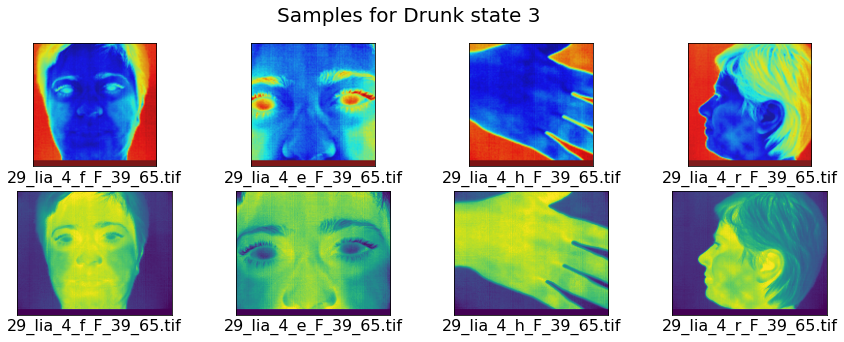

In [ ]:
demo_img_path = '/content/drive/MyDrive/DeepLearning_Assignment_Drunk_Sober_Classify/01_petros'
person = list(sober_dict.keys())[2]
print(f'Demo of single person images named {person}')
print('Each of 2nd row is the actual image, and 1st row is the colomap trnsformed image!')
print(f'Person {person}')
for i, dict_ in enumerate(class_dict_list):
  fig = plt.figure(figsize=(15,5))
  fig.suptitle(f'Samples for {available_classifiers_list[i]}', fontsize = 20)
  plt.tight_layout()
  for j, img_sample in enumerate(dict_[person]):
    img_path = os.path.join(dataset_path, person, img_sample)
    demo_img = img_preprocess(img_path)
    fig.add_subplot(2,4,j+1)
    plt.imshow(demo_img)
    plt.xlabel(img_sample, fontsize=16)
    plt.xticks([])
    plt.yticks([])
    fig.add_subplot(2,4,j+1+4)
    plt.imshow(plt.imread(img_path))
    plt.xlabel(img_sample, fontsize=16)
    plt.xticks([])
    plt.yticks([])
    

plt.show()

In [ ]:
print(f'Classifiers list {classifiers_list}')

id_list = [i for i in range(len(classifiers_list))]

# labels distionary
label_dict = dict(zip(classifiers_list, id_list))

print(f'Classifiers dictionary\n{label_dict}')

Classifiers list ['Sober state', 'Drunk state']
Classifiers dictionary
{'Sober state': 0, 'Drunk state': 1}


#### **Prepare Train, Valid, Test data and label pair**



In [ ]:
# define input, output data prep func.
def dataset_prep(image_df): 
  # input image array list
  x = []
  # output label list
  y = [] 
  for img_path, label in zip(image_df.loc[:,'Image'], image_df.loc[:,'Label']):
    # image conversion
    img = img_preprocess(img_path)
    # image append to list
    x.append(img)
    # label id for sparse categorical crossentropy
    label_id = label_dict[label]
    # append label_id
    y.append(label_id)
  
  # returns input, label list
  return x, y

**Obtain train dataset and label pair**

In [ ]:
# train input list
x_train = []
# train output list
y_train = []

# fetch train input, label usinng dataset_prep having attribute is train_df
print('Fetching training data...')
x_train, y_train = dataset_prep(train_df)
assert len(x_train) == len(y_train)
print('Train data prep is done successfully!')

Fetching training data...
Train data prep is done successfully!


**Obtain validation dataset and label pair**

In [ ]:
# valid input list
x_valid = []
# valid output list
y_valid = []

# fetch valid input, label usinng dataset_prep hving attribute is valid_df
print('Fetching validation data...')
x_valid, y_valid = dataset_prep(valid_df)
assert len(x_valid) == len(y_valid)
print('Validation data prep is done successfully!')

Fetching validation data...
Validation data prep is done successfully!


**Obtain test dataset and label pair**

In [ ]:
# test input list
x_test = []
# train output list
y_test = []

# fetch test input, label usinng dataset_prep hving attribute is test_df
print('Fetching test data...')
x_test, y_test = dataset_prep(valid_df)
assert len(x_test) == len(y_test)
print('Test data prep is done successfully!')

Fetching test data...
Test data prep is done successfully!


#### **Transforming dataset Numpy array**

In [ ]:
# train data conversion
x_train, y_train = np.array(x_train), np.array(y_train, dtype=np.int32)
# valid data conversion
x_valid, y_valid = np.array(x_valid), np.array(y_valid, dtype=np.int32)
# test data conversion
x_test, y_test = np.array(x_test), np.array(y_test, dtype=np.int32)

In [ ]:
print(f'Train shape, data-type :\n{x_train.shape}, {x_train.dtype}\n{y_train.shape}, {y_train.dtype}')
print(f'Validation shape, data-type :\n{x_valid.shape}, {x_valid.dtype}\n{y_valid.shape}, {y_valid.dtype}')
print(f'Test shape, data-type :\n{x_test.shape}, {x_test.dtype}\n{y_test.shape}, {y_test.dtype}')


# assertion checks
assert x_train.dtype == x_valid.dtype == x_test.dtype == np.float32
assert y_train.dtype == y_valid.dtype == y_test.dtype == np.int32
assert len(x_train.shape) ==  len(x_valid.shape) == len(x_test.shape) == 4

print('All assertion checks are done successfully')

Train shape, data-type :
(584, 256, 256, 3), float32
(584,), int32
Validation shape, data-type :
(32, 256, 256, 3), float32
(32,), int32
Test shape, data-type :
(32, 256, 256, 3), float32
(32,), int32
All assertion checks are done successfully


#### **Implement Augmentation**

From the consistency of all the augmentation techniques for different poses we are only considering
* Brightness
* Autocontrast
* Sharpness
* Flip
* Inverse(Training can be done for with Invert, without invert for all above augmentations)


Define image aug function for the dataset having the specified class index


In [51]:
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

# image aug function for the dataset having the specified class index
def img_aug(dataset,label, class_idx = 0):
  # fetch the index of the given class idx
  idx_list = [i for i,j in enumerate(label) if j==class_idx]

  # define augmentor objects for auto_contrast, flip with prob=1
  auto_contrast = iaa.pillike.Autocontrast()
  flip = iaa.Fliplr(p=1)
  
  img_list = list(dataset)

  # augmented images list initialized with dataset
  aug_list = img_list
  # augmented label list initiallized with dataset
  aug_label_list = list(label)
  
  for idx in idx_list:
    img = img_list[idx]
    
    # auto contrast
    img = convert(img,0,255,np.uint8)
    img = auto_contrast.augment_image(img)
    img = convert(img,0,1,np.float32)
    aug_list.append(img)
    aug_label_list.append(class_idx)
    
    # flip
    img = convert(img,0,255,np.uint8)
    img = flip.augment_image(img)
    img = convert(img,0,1,np.float32)
    aug_list.append(img)
    aug_label_list.append(class_idx)

  aug_img_array = np.array(aug_list, dtype=np.float32)
  aug_label_list_array = np.array(aug_label_list, dtype=np.int32) 
  
  assert aug_img_array.shape[0] == aug_label_list_array.shape[0]
  
  return aug_img_array, aug_label_list_array 

**Implement augmentation for "sober class" by appending the augmented samples to copy of list of actual samples**

Train augmentation

In [52]:
aug_imgs, aug_labels = img_aug(x_train, y_train)
print(aug_imgs.shape, aug_imgs.dtype)
print(aug_labels.shape, aug_labels.dtype)

NameError: ignored

Distribution after augmentation

In [ ]:
collections.Counter(aug_labels)

Valid augmentation

In [ ]:
val_aug_imgs, val_aug_labels = img_aug(x_valid, y_valid)
print(val_aug_imgs.shape, val_aug_imgs.dtype)
print(val_aug_labels.shape, val_aug_labels.dtype)

Distribution after augmentation

In [ ]:
collections.Counter(val_aug_labels)

#### **Image pre-peocessing and data preperation using keras ImageDataGenerator**

* For the flow batch size = 32, shuffle = True, class_mode = Sparse, seed = 1 used.

* Rescaling is not used here, keeping the image as it is
[Reference](https://keras.io/api/preprocessing/image/)

In [ ]:
# define batch size based on which datagen will prepare the data
batch_size = 32

In [ ]:
# creating imagedatagenerator object using keras
datagen = ImageDataGenerator(rotation_range=None,
                                   width_shift_range = None,
                                   height_shift_range = None,
                                   brightness_range = None,
                                   zoom_range = 0.0,
                                   #rescale = 1./255.,
                                   preprocessing_function = None,
                                   dtype = np.float32,
                                   )

# provide same seed and keyword arguments to the fit and flow methods 
seed = 1

# obtaining images from augmented train dataset and apply augmentation using datagen to create batches
train_generator = datagen.flow(
                              aug_imgs,
                              y=aug_labels,
                              batch_size=batch_size,
                              shuffle=True,
                              sample_weight=None,
                              seed=seed,
                              save_to_dir=None,
                              save_prefix="",
                              #save_format="png",
                              subset=None,
                          )

# obtaining images from validation dataset and apply augmentation using datagen to create batches
valid_generator = datagen.flow(
                              val_aug_imgs,
                              y=val_aug_labels,
                              batch_size=batch_size,
                              shuffle=True,
                              sample_weight=None,
                              seed=seed,
                              save_to_dir=None,
                              save_prefix="",
                              #save_format="png",
                              subset=None,
                          )

# obtaining images from test dataset and apply augmentation using datagen to create batches
test_generator = datagen.flow(
                              x_test,
                              y=y_test,
                              batch_size=batch_size,
                              shuffle=True,
                              sample_weight=None,
                              seed=seed,
                              save_to_dir=None,
                              save_prefix="",
                              #save_format="png",
                              subset=None,
                          )

**Sample images after datagen**

In [ ]:
def img_label_samples(train_generator, class_count = 4):
  '''
  Fetches 1st sample of each class from 0 to 61
  Along with the class label or id
  Takes total class samples to be visualized 
  Batch count as attributes
  '''
  # total batches in the train datagenerator
  batch_count = len(train_generator)
  # image list initialization
  img_list = []
  # labels list
  labels = []

  for cls in range(class_count):
    for batch in range(batch_count):
      # traversing through image label or class id
      # O-> Batch, 1-> Class(for 1, 0 for image), 2-> Index of each image in the batch(0 to 31)
      for i, j in enumerate(train_generator[batch][1][:]):
        if int(j)==cls:
          img_list.append(train_generator[batch][0][i])
          labels.append(int(j))
          break
      if int(j) == cls:
        break
  return img_list, labels

Sample image of label 0


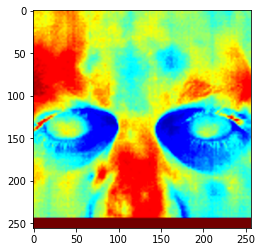

Sample image of label 1


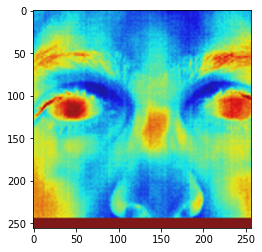

In [ ]:
# obtain sample image and label list from train_generator
img_list, labels = img_label_samples(train_generator)

for sample_img, sample_label in zip(img_list, labels):
  print(f'Sample image of label {sample_label}')
  plt.imshow(sample_img, cmap = None)
  plt.show()

**Checking the resize result on the sample images using "Bicubic Interpolation"**

Sample image of label 0


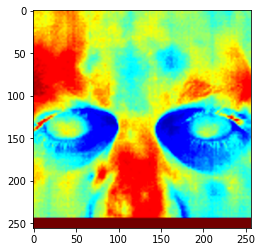

In [ ]:
# applying bicubic spline interpolation on the above images
for sample_img, sample_label in zip(img_list, labels):
  print(f'Sample image of label {sample_label}')
  plt.imshow(tf.keras.preprocessing.image.smart_resize(sample_img, size=(256,256), interpolation='bicubic'))
  break

## **CNN Model Building** 

Testing with different pre-trained CNN models using transfer learning and also some custom models training from scratch

In [ ]:
# input image shape
input_shape = (256,256,3)

# num of classes
class_num = 1 #for binary classification

**Load the pre-trained model**

1. EfficientNetB2 model

In [ ]:
input_tensor = tf.keras.layers.Input(shape = (256,256,3))

# using effifientnetB2 where the image size (260,260,3) 
efficientnet = tf.keras.applications.EfficientNetB2(
    input_tensor = input_tensor,
    include_top = True, # include top is false as we want only 1 class here
    weights = "imagenet"
)
transfer_model = efficientnet
print('Model weights are loaded!')
#efficientnet.summary()

37437440/37432240 [==============================] - 0s 0us/step
Model weights are loaded!


2. Nasnetmobile

In [ ]:
input_tensor = tf.keras.layers.Input(shape = (256,256,3))

# using effifientnetB2 where the image size (260,260,3) 
nasnet = tf.keras.applications.NASNetMobile(
    input_tensor = input_tensor,
    include_top = True, # include top is false as we want only 1 class here
    weights = "imagenet"
)
transfer_model = nasnet
print('Model weights are loaded!')
#transfer_model.summary()

Model weights are loaded!


#### **Transfer Learning**

In [ ]:
x = transfer_model.layers[-2].output
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Dense(1000, activation='relu')(x)
#x = tf.keras.layers.Dense(512, activation='relu')(x)
#x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(class_num, activation='sigmoid')(x)

model = tf.keras.Model(inputs = transfer_model.input, outputs = x)
#model.summary()

**Define training states of the pretrained model training layers**

In [ ]:
# defines whether the layers or which layers will be set for training or freezed
for layer in transfer_model.layers:
  layer.trainable = True

#### **Define a custom base Model**

In [ ]:
def base_model(input_shape, num_classes):
  inputs = tf.keras.layers.Input(shape = input_shape)

  x = tf.keras.layers.Conv2D(filters = 16, kernel_size=(3,3), activation='relu', strides=(1,1))(inputs)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', strides=(1,1))(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', strides=(1,1))(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', strides=(1,1))(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', strides=(1,1))(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1000, activation='relu')(x)
  x = tf.keras.layers.Dropout(rate = 0.3)(x)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  return tf.keras.Model(inputs = inputs, outputs = output)

base_model = base_model(input_shape, 1)
base_model.summary()
# save model structure image
#plot_model(base_model, to_file = 'potato_cnn_base.png')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0     

#### **Initialize wandb to log training**


[Reference](https://github.com/wandb/client)

[Reference notebook](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-artifacts/Pipeline_Versioning_with_W&B_Artifacts.ipynb#scrollTo=XZ3dp-1jCbEG)

**Define model artifact metadata**

In [ ]:
# artifact id as projet name
model_artifact_id = "Drunk_detection_from_infrared_image"
# artifact name
model_artifact_name = "drunk_convnet"

# config dict for model
model_config = {"num_classes": class_num,
                "input_shape": input_shape
}

# define which model to log whether transfer learning one or custom
# uncomment to load pre-trained model
#logged_model = model
# uncomment to load base model
logged_model = base_model

In [ ]:
!pwd
%cd /content/

/content
/content


## **Configure Model Training**

#### **Define Training metadata**

In [ ]:
# learning rate
learning_rate = 0.001 # initial lr

# epochs no.
epochs = 30

# loss function
loss_fn = tf.keras.losses.BinaryCrossentropy()

# optimizer
optim = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# define class_weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(aug_labels), aug_labels)

# weights dict
class_ids = [i for i in range(len(class_weights))]

weight_dict = dict(zip(class_ids, class_weights))
print(f'Class weights\n{weight_dict}')

Class weights
{0: 0.990990990990991, 1: 1.0091743119266054}


**Define training metrics**

Define true-positive, false-positive, true-negative, false-negative, precision, recall, area under curve for precision-recall curve

In [ ]:
METRICS = [
           tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalsePositives(name='fp'),
           tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.FalseNegatives(name='fn'),
           tf.keras.metrics.BinaryAccuracy(name='acc'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]

#### **Define Training steps for train and log to wandb**

**Training metadata**

In [ ]:
# train artifact name
train_artifact_name = "drunk_detection_training"

# configure callbacks
callback_config = {"log_weights": True, # ensured weights will be logged to wandb
                   "save_model": True,
                   "log_batch_frequency": 10, # log training after 10 batch
                   "verbose": 1
}

# define train config
train_config = {"batch_size": batch_size,
                "epochs": epochs,
                "optimizer": optim,
                "callback_config": callback_config
}

print('Training configuration')
train_config

Training configuration


{'batch_size': 32,
 'callback_config': {'log_batch_frequency': 10,
  'log_weights': True,
  'save_model': True,
  'verbose': 1},
 'epochs': 30,
 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7fb29195c190>}

**Initialize the wandb project**

In [ ]:
'''
 Instruction: Initialize everytime before using wandbcallback and run.join()
'''
# initialize wandb with the project
run = wandb.init(project=model_artifact_id,
                 config = train_config)

config = wandb.config # will be used to configure the experiment

# clearing session
tf.keras.backend.clear_session()

wandb: Currently logged in as: sayan0506 (use `wandb login --relogin` to force relogin)


#### **Define Callbacks**

In [ ]:
# initially error is too high so starting from LR 1e-01 as the initial LR
# learning rate scheduler to obtain optimum LR
# schedule is exponential decaying LR
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-03/(epoch+1))

# if it observes val_acc is stuck in a plateu, reduces learning_rate by factor 0.2 with patience = 5
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc',
                                                 factor = 0.2,
                                                 patience = 5) 

# model checkpoint for transfer learning model
filepath_transfer = 'transfer_model_epoch{epoch:02d}-acc {val_acc:0.4f}.hdf5'
mc_transfer = ModelCheckpoint(filepath = filepath_transfer, monitor='val_acc', save_weights_only=True,mode = 'max', verbose = 1, save_best_only=False)

# model checkpoint for base model
filepath_base = 'base_model_epoch{epoch:02d}-acc {val_acc:0.4f}.hdf5'
mc_base = ModelCheckpoint(filepath=filepath_base, monitor='val_acc', save_weights_only=True,mode = 'max', verbose = 1, save_best_only=False)

wandb_callback = WandbCallback(save_model=False, monitor='val_loss')

**Callback list for transfer model**

In [ ]:
callbacks_transfer = [lr_schedule, reduce_lr, mc_transfer, wandb_callback, PlotLossesKeras()]

**Callback list for base model**

In [ ]:
callbacks_base = [lr_schedule, reduce_lr, mc_base, wandb_callback, PlotLossesKeras()]

#### **Model Compile**

In [ ]:
# compile the model
logged_model.compile(optimizer=train_config['optimizer'], loss = loss_fn, metrics=METRICS)
print('Done compiling!')

Done compiling!


#### **Define train fn**

In [ ]:
def train(model, training, validation, callbacks, config, weight_dict = None):
  '''
  defining model training steps
  '''
  print(model.summary())
  try:
    with wandb.init(project = model_artifact_id, job_type = "train", config = train_config) as run:
      print('STarting training....')
      # defining model fit 
      # passing train datagenerator, validation data generator
      history = model.fit(training, validation_data = validation, 
                # batch_size = config.batch_size, # batch size is mentioned while building data generator
                epochs = config['epochs'],
                callbacks = callbacks,
                verbose = 1,
                class_weight = weight_dict #pass class weight dictionary
      )

    return history

  except Exception as e:
    logging.exception('message')

####**Define function to plot evaludation metrics**

In [ ]:
def plot_metrics(model, x, y, p=0.25):
  # get model predictions
  y_pred = model.predict(x)
  # obtains predictions based on robability
  predictions = y_pred>p
  print(f'Classification Report for the model\n{metrics.classification_report(y, predictions)}\n')
  print(f'\nClassification accuracy: {metrics.accuracy_score(y, predictions)*100: 0.2f}\n')
  print('Confusion matrix')
  sns.heatmap(confusion_matrix(y, predictions), annot = True)
  plt.show()

#### **Define ROC curve function**

In [ ]:
def plot_roc(name, model, x, y, dataset, p=0.25):
  # get model predictions
  y_pred = model.predict(x)
  # obtains predictions based on robability
  predictions = y_pred>p
  tp, fp = metrics.roc_curve(y, predictions)

  plt.plot(100*fp, 10*tp, label = name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([0, 450])
  plt.ylim([0,450])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')


## **Model Training**

#### **Train Transfer Learning model**
1. EfficientnetB2 train

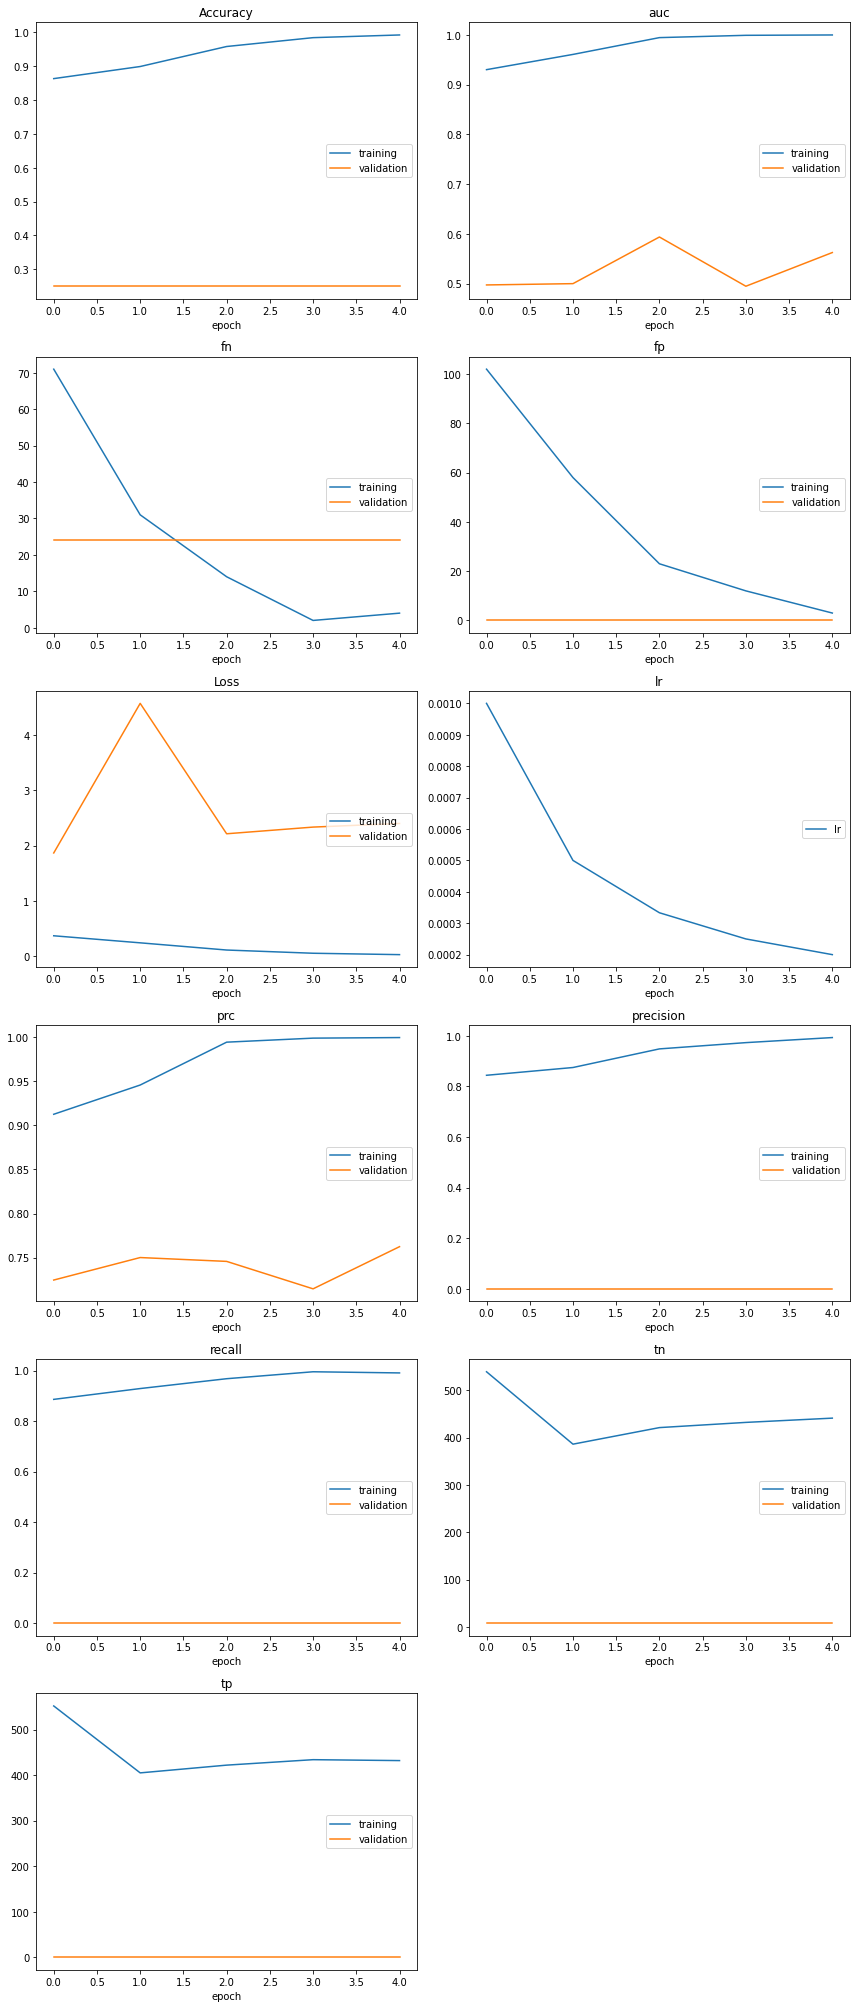

Accuracy
	training         	 (min:    0.863, max:    0.992, cur:    0.992)
	validation       	 (min:    0.250, max:    0.250, cur:    0.250)
auc
	training         	 (min:    0.930, max:    1.000, cur:    1.000)
	validation       	 (min:    0.495, max:    0.594, cur:    0.562)
fn
	training         	 (min:    2.000, max:   71.000, cur:    4.000)
	validation       	 (min:   24.000, max:   24.000, cur:   24.000)
fp
	training         	 (min:    3.000, max:  102.000, cur:    3.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    0.029, max:    0.370, cur:    0.029)
	validation       	 (min:    1.867, max:    4.571, cur:    2.400)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
prc
	training         	 (min:    0.913, max:    1.000, cur:    1.000)
	validation       	 (min:    0.714, max:    0.762, cur:    0.762)
precision
	training         	 (min:    0.844, max:    0.993, cur:    0.993)
	validation       	 (min:    0.000,

KeyboardInterrupt: ignored

In [ ]:
history_effb2 = train(logged_model, train_generator, valid_generator, callbacks_transfer, train_config, weight_dict=weight_dict)

2. Nasnet train

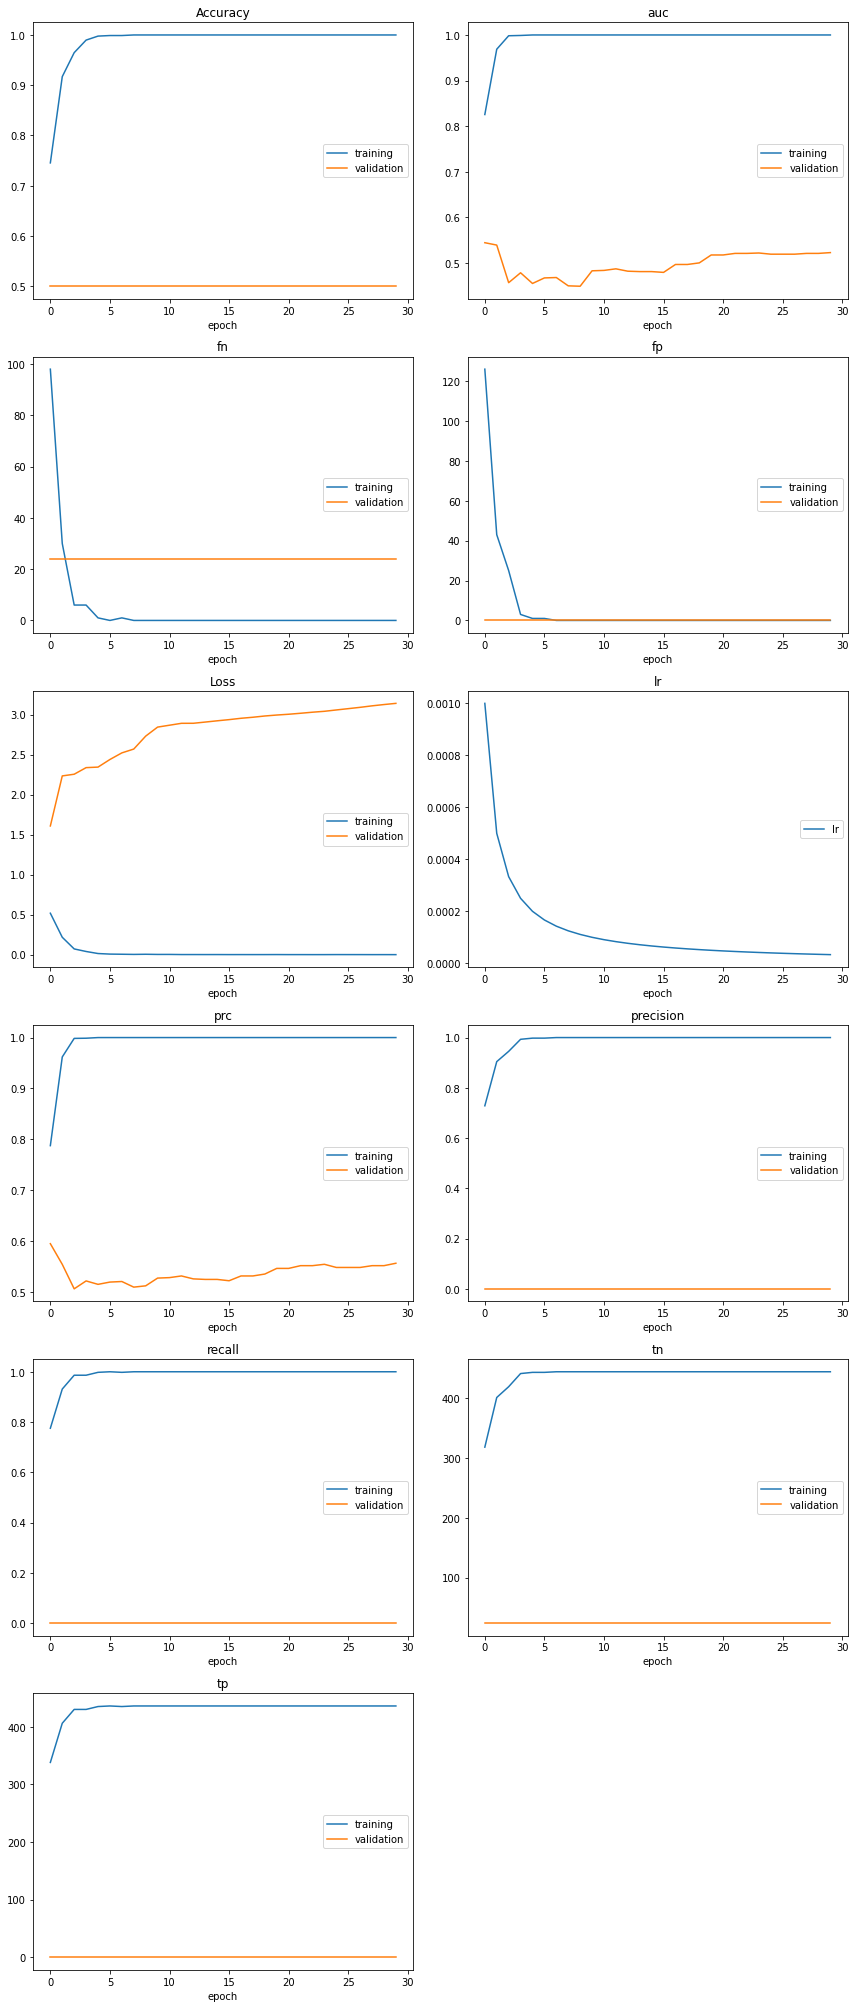

Accuracy
	training         	 (min:    0.745, max:    1.000, cur:    1.000)
	validation       	 (min:    0.500, max:    0.500, cur:    0.500)
auc
	training         	 (min:    0.825, max:    1.000, cur:    1.000)
	validation       	 (min:    0.449, max:    0.544, cur:    0.523)
fn
	training         	 (min:    0.000, max:   98.000, cur:    0.000)
	validation       	 (min:   24.000, max:   24.000, cur:   24.000)
fp
	training         	 (min:    0.000, max:  126.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    0.000, max:    0.518, cur:    0.000)
	validation       	 (min:    1.608, max:    3.139, cur:    3.139)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
prc
	training         	 (min:    0.788, max:    1.000, cur:    1.000)
	validation       	 (min:    0.506, max:    0.595, cur:    0.557)
precision
	training         	 (min:    0.728, max:    1.000, cur:    1.000)
	validation       	 (min:    0.000,

In [ ]:
history_nasnet = train(logged_model, train_generator, valid_generator, callbacks_transfer, train_config, weight_dict=weight_dict)

#### **Train Base model**

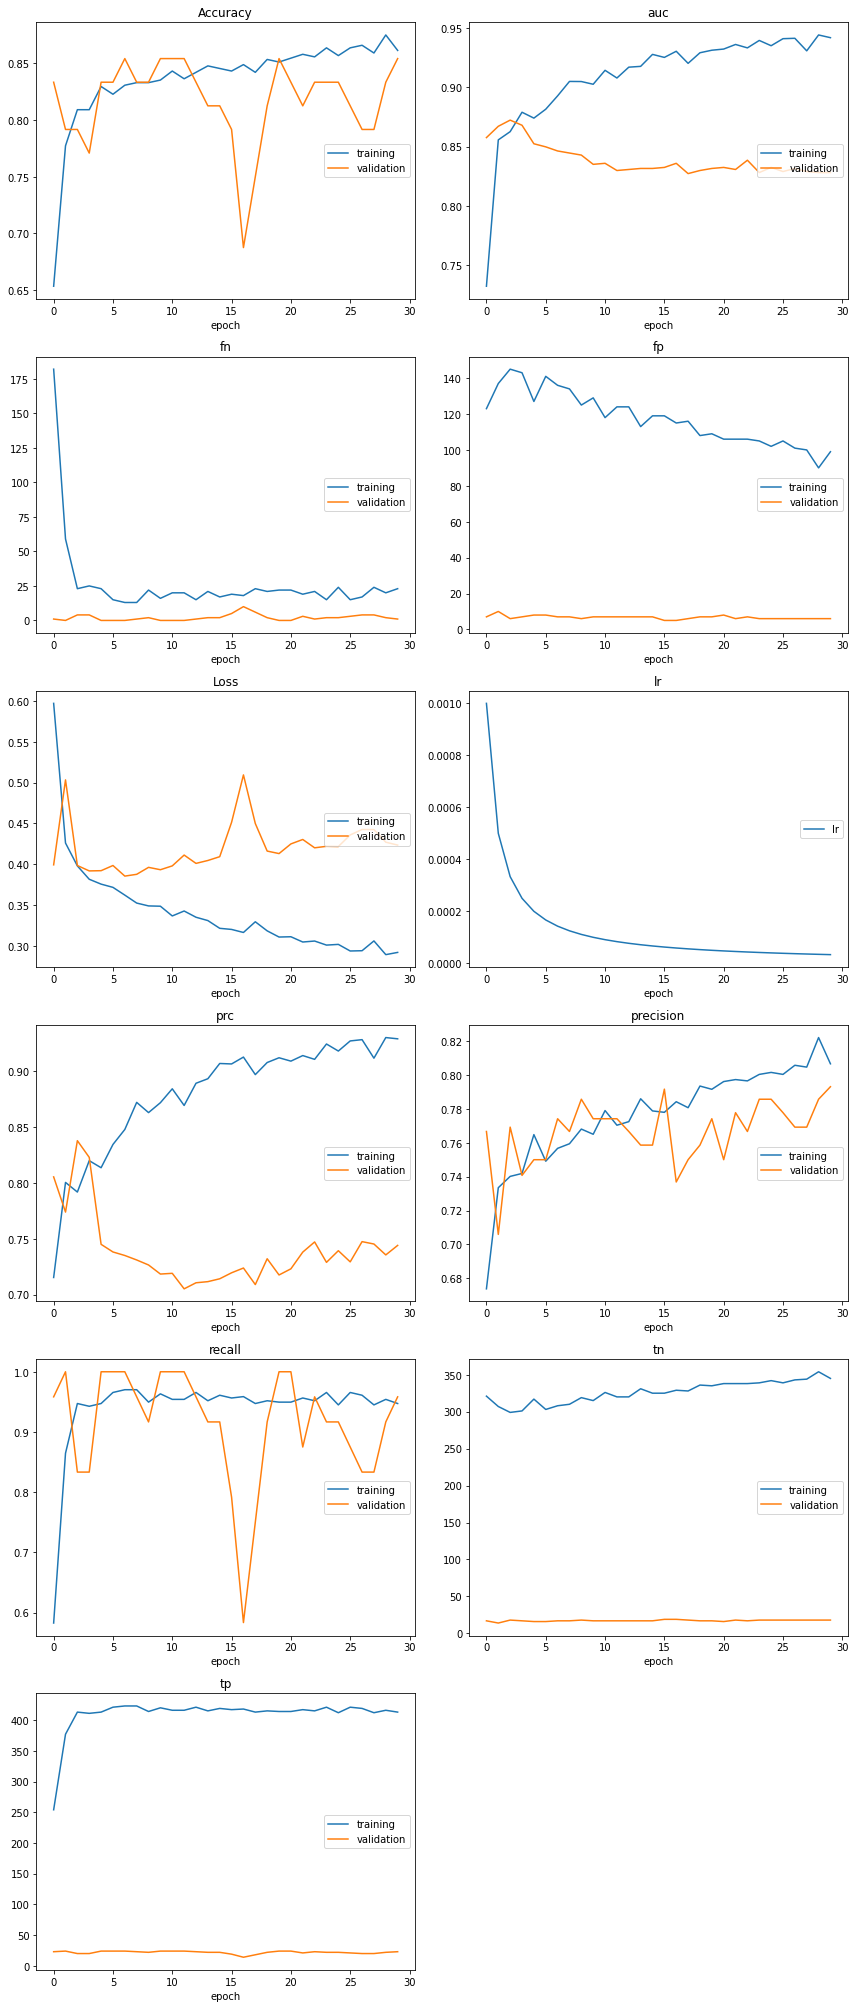

Accuracy
	training         	 (min:    0.653, max:    0.875, cur:    0.861)
	validation       	 (min:    0.688, max:    0.854, cur:    0.854)
auc
	training         	 (min:    0.732, max:    0.944, cur:    0.942)
	validation       	 (min:    0.827, max:    0.872, cur:    0.828)
fn
	training         	 (min:   13.000, max:  182.000, cur:   23.000)
	validation       	 (min:    0.000, max:   10.000, cur:    1.000)
fp
	training         	 (min:   90.000, max:  145.000, cur:   99.000)
	validation       	 (min:    5.000, max:   10.000, cur:    6.000)
Loss
	training         	 (min:    0.290, max:    0.597, cur:    0.292)
	validation       	 (min:    0.386, max:    0.509, cur:    0.424)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
prc
	training         	 (min:    0.715, max:    0.930, cur:    0.929)
	validation       	 (min:    0.705, max:    0.838, cur:    0.744)
precision
	training         	 (min:    0.674, max:    0.822, cur:    0.807)
	validation       	 (min:    0.706,

In [ ]:
history_base = train(logged_model, train_generator, valid_generator, callbacks_base, train_config, weight_dict=weight_dict)

## **Evaluation**
**Evaluate Transfer Learning model**
1. EfficientnetB2


In [ ]:
logged_model.load_weights('/content/base_model_epoch03-acc 0.7500.hdf5')

Classification Report for the model
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       444
           1       0.76      0.93      0.84       436

    accuracy                           0.82       880
   macro avg       0.84      0.82      0.82       880
weighted avg       0.84      0.82      0.82       880



Classification accuracy:  82.27

Confusion matrix


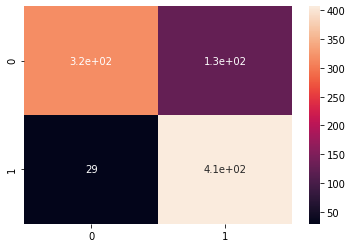

In [ ]:
plot_metrics(logged_model, aug_imgs, aug_labels)

Classification Report for the model
              precision    recall  f1-score   support

           0       0.17      0.12      0.14         8
           1       0.73      0.79      0.76        24

    accuracy                           0.62        32
   macro avg       0.45      0.46      0.45        32
weighted avg       0.59      0.62      0.61        32



Classification accuracy:  62.50

Confusion matrix


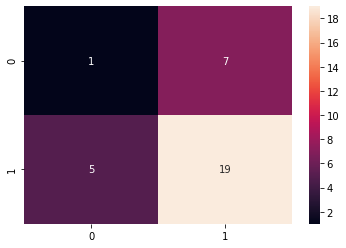

In [ ]:
plot_metrics(logged_model, x_valid, y_valid)

Classification Report for the model
              precision    recall  f1-score   support

           0       0.17      0.12      0.14         8
           1       0.73      0.79      0.76        24

    accuracy                           0.62        32
   macro avg       0.45      0.46      0.45        32
weighted avg       0.59      0.62      0.61        32



Classification accuracy:  62.50

Confusion matrix


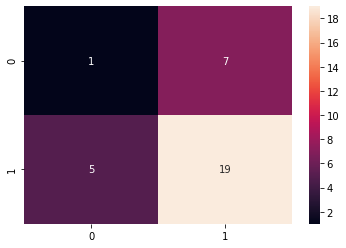

In [ ]:
plot_metrics(logged_model, x_test, y_test)

2. Nasnet result with valid_aug

Classification Report for the model
              precision    recall  f1-score   support

           0       0.51      1.00      0.67       444
           1       1.00      0.00      0.00       436

    accuracy                           0.51       880
   macro avg       0.75      0.50      0.34       880
weighted avg       0.75      0.51      0.34       880



Classification accuracy:  50.57

Confusion matrix


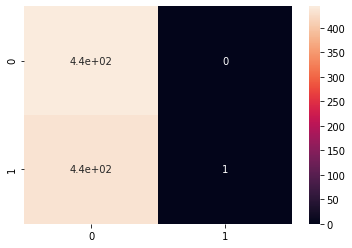

Classification Report for the model
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        24
           1       0.00      0.00      0.00        24

    accuracy                           0.50        48
   macro avg       0.25      0.50      0.33        48
weighted avg       0.25      0.50      0.33        48



Classification accuracy:  50.00

Confusion matrix


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


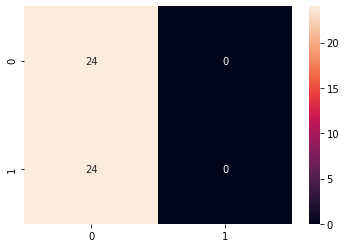

Classification Report for the model
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         8
           1       0.00      0.00      0.00        24

    accuracy                           0.25        32
   macro avg       0.12      0.50      0.20        32
weighted avg       0.06      0.25      0.10        32



Classification accuracy:  25.00

Confusion matrix


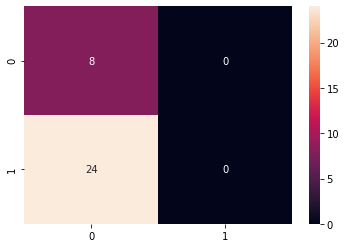

In [ ]:
logged_model.load_weights('/content/transfer_model_epoch01-acc 0.5000.hdf5')
plot_metrics(logged_model, aug_imgs, aug_labels)
plot_metrics(logged_model, val_aug_imgs, val_aug_labels)
plot_metrics(logged_model, x_test, y_test)

**Base model**

After Training

Classification Report for the model
              precision    recall  f1-score   support

           0       1.00      0.68      0.81       444
           1       0.75      1.00      0.86       436

    accuracy                           0.84       880
   macro avg       0.88      0.84      0.83       880
weighted avg       0.88      0.84      0.83       880



Classification accuracy:  83.86

Confusion matrix


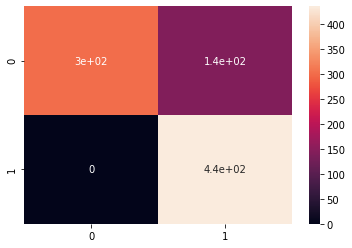

Classification Report for the model
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        24
           1       0.75      1.00      0.86        24

    accuracy                           0.83        48
   macro avg       0.88      0.83      0.83        48
weighted avg       0.88      0.83      0.83        48



Classification accuracy:  83.33

Confusion matrix


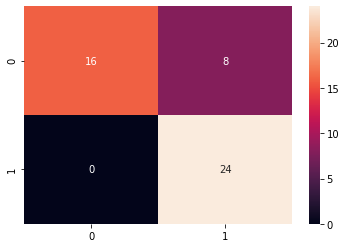

Classification Report for the model
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.77      1.00      0.87        24

    accuracy                           0.78        32
   macro avg       0.89      0.56      0.55        32
weighted avg       0.83      0.78      0.71        32



Classification accuracy:  78.12

Confusion matrix


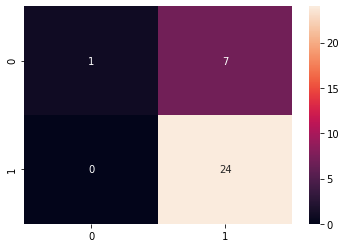

In [ ]:
#logged_model.load_weights('/content/transfer_model_epoch01-acc 0.5000.hdf5')
plot_metrics(logged_model, aug_imgs, aug_labels)
plot_metrics(logged_model, val_aug_imgs, val_aug_labels)
plot_metrics(logged_model, x_test, y_test)

Recommended best model after training

Classification Report for the model
              precision    recall  f1-score   support

           0       1.00      0.64      0.78       444
           1       0.73      1.00      0.84       436

    accuracy                           0.82       880
   macro avg       0.87      0.82      0.81       880
weighted avg       0.87      0.82      0.81       880



Classification accuracy:  81.82

Confusion matrix


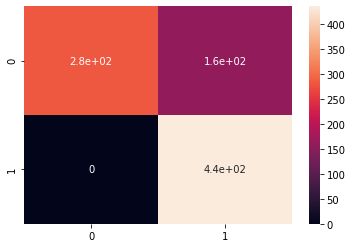

Classification Report for the model
              precision    recall  f1-score   support

           0       1.00      0.62      0.77        24
           1       0.73      1.00      0.84        24

    accuracy                           0.81        48
   macro avg       0.86      0.81      0.81        48
weighted avg       0.86      0.81      0.81        48



Classification accuracy:  81.25

Confusion matrix


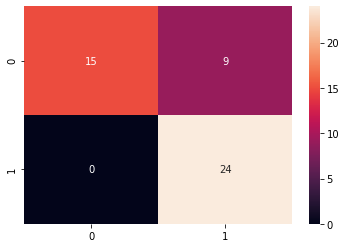

Classification Report for the model
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.75      1.00      0.86        24

    accuracy                           0.75        32
   macro avg       0.38      0.50      0.43        32
weighted avg       0.56      0.75      0.64        32



Classification accuracy:  75.00

Confusion matrix


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


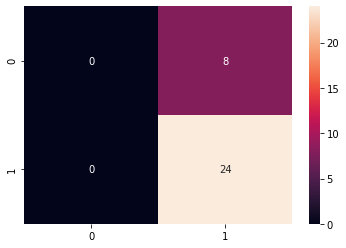

In [ ]:
logged_model.load_weights('/content/base_model_epoch07-acc 0.8542.hdf5')
plot_metrics(logged_model, aug_imgs, aug_labels)
plot_metrics(logged_model, val_aug_imgs, val_aug_labels)
plot_metrics(logged_model, x_test, y_test)

**Algos for evaluation**

1. **GradCAM:** Visualizing the CNN last layers using Gradient Class Activation Map to understand the portion in the image, where the CNN is looking for classification.

  [Reference](https://keras.io/examples/vision/grad_cam/), Couresera CV week 4.

2. **Saliency Map:** Saliency Map helps to reprsent to pixels of the image to a different domain, thus from saliency map it's better to understand which pixels contributed to that classiification. 

  a. [Coursera Advanced CV week 4](https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow/supplement/M1Td3/reference-gradcam)
  
  b. [Saliency Notebook, keras_vis detailed implementation guide](https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb)

Note: 
[Opencv Colormap guide](https://docs.opencv.org/master/d3/d50/group__imgproc__colormap.html)


## **Visualizing GadCAM**

In [ ]:
# implementing gradcam
def make_gradcam_heatmap(img_array, model, layer_name = None, pred_index=None):
    # if layer name is not given considering the last layer then
    last_conv_layer_name = layer_name
    if last_conv_layer_name == None:
      for layer in reversed(model.layers):
      #for layer in model.layers[:10]:
        if len(layer.output_shape) == 4:
          last_conv_layer_name = layer.name

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, save = None, cam_path=None, alpha=0.7):
    # alpha defines the percentage of overlay, alpha reduces the output will be more close to actual
    # Load the original image
    #img = keras.preprocessing.image.load_img(img_path)
    #img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    #fig = plt.figure(figsize=(10,10))
    #plt.imshow(superimposed_img)

    # Save the superimposed image if save!=None
    if save!=None:
      superimposed_img.save(cam_path)
    return superimposed_img

    # Display Grad CAM
    #display(Image(cam_path))



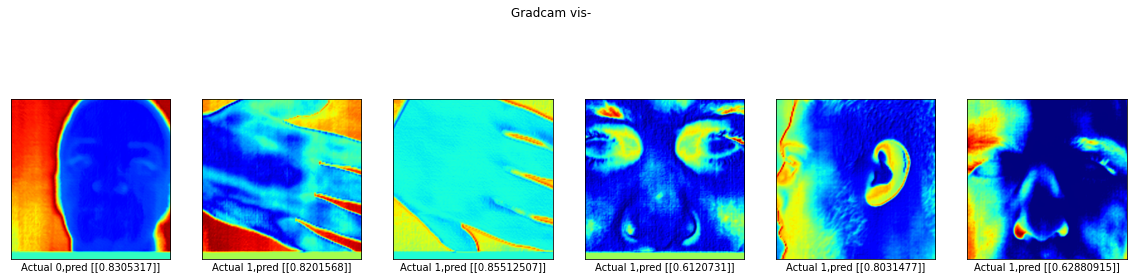

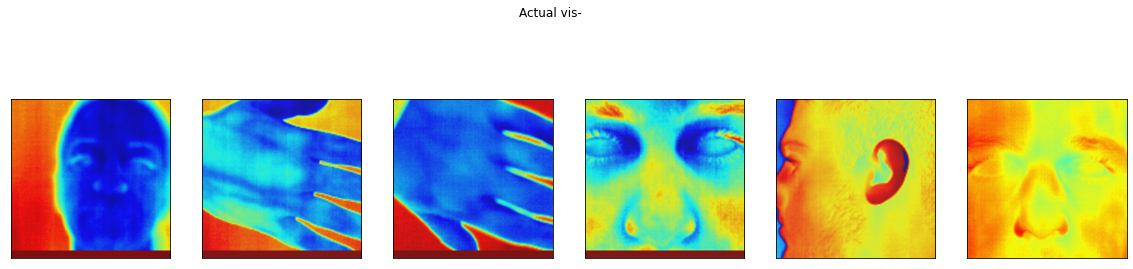

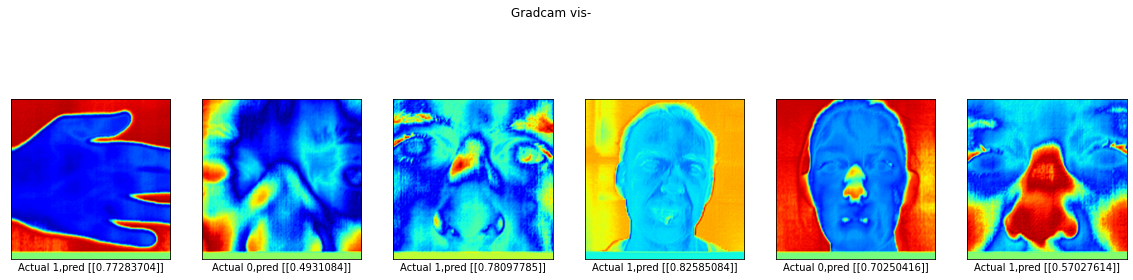

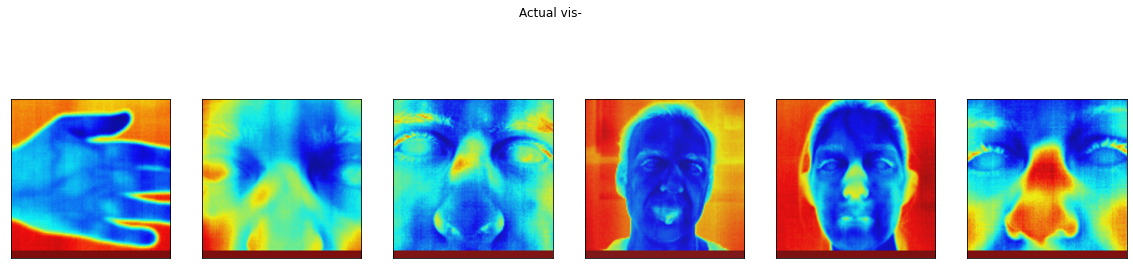

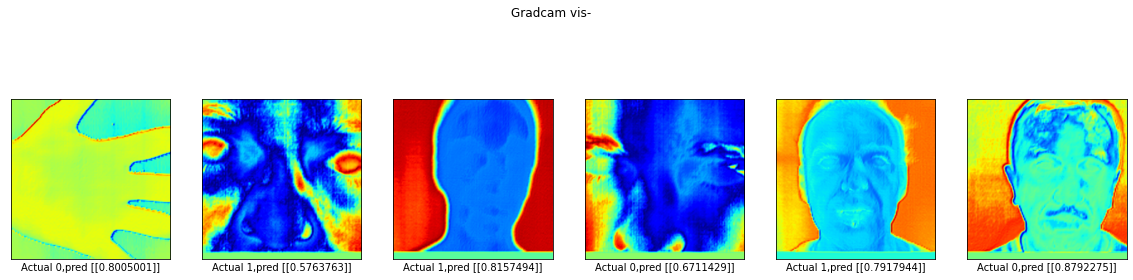

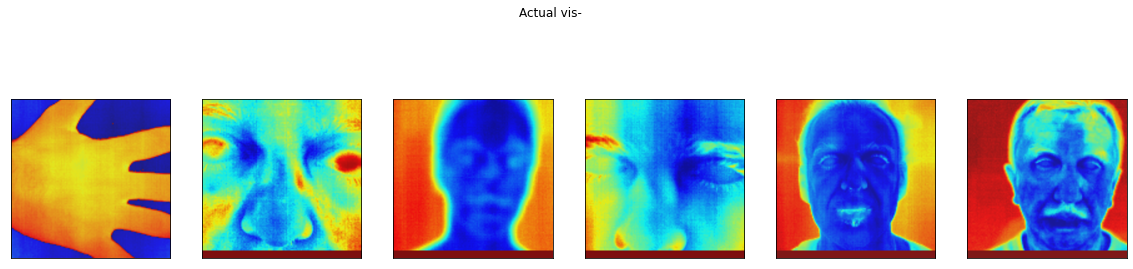

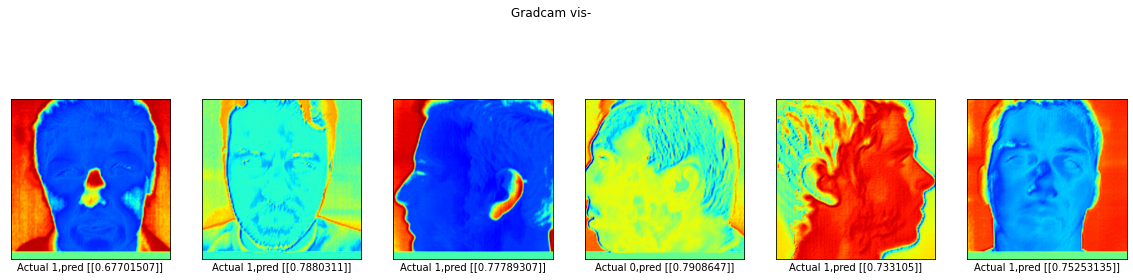

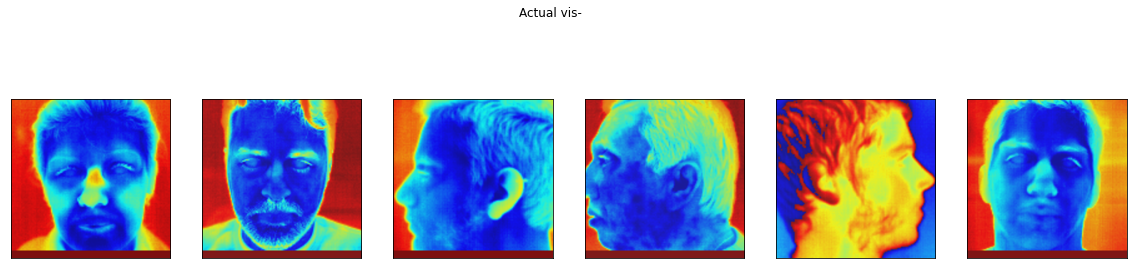

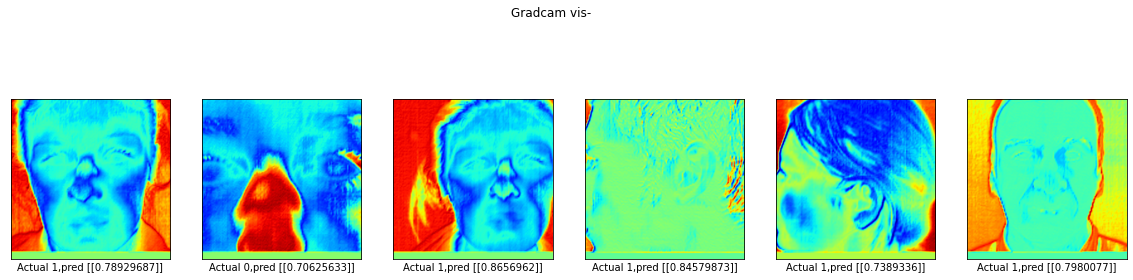

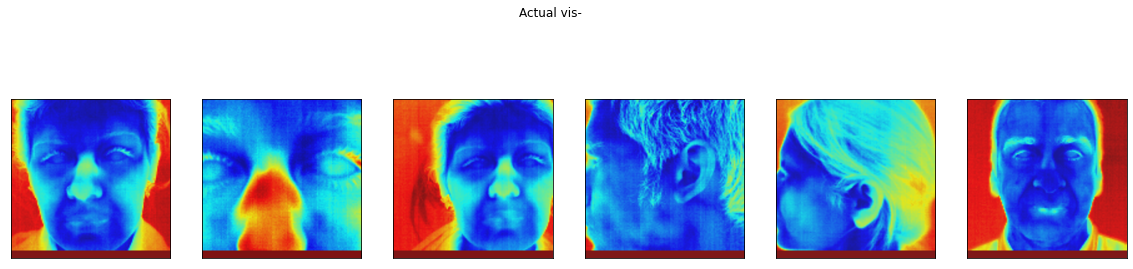

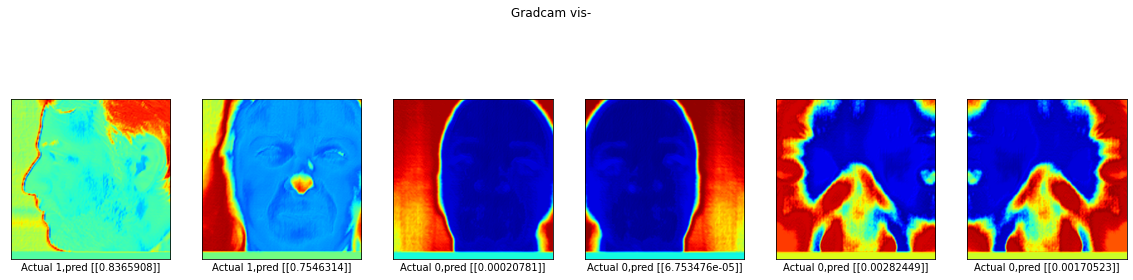

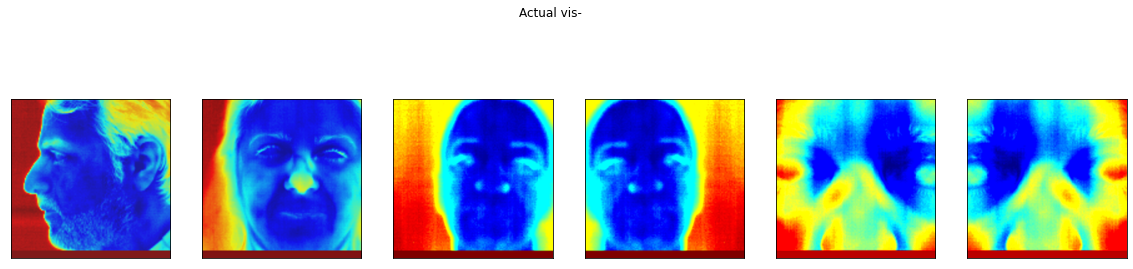

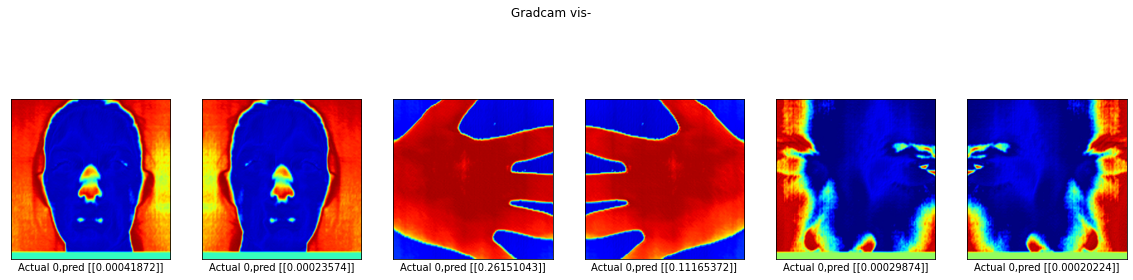

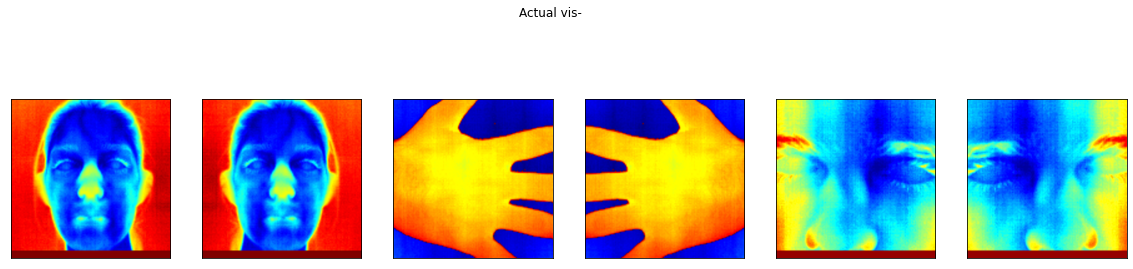

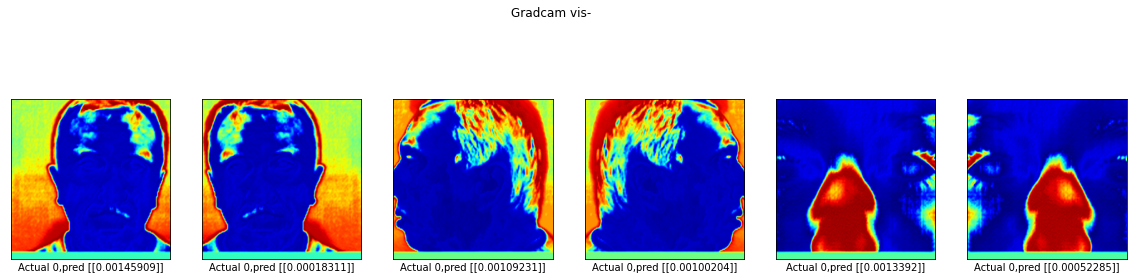

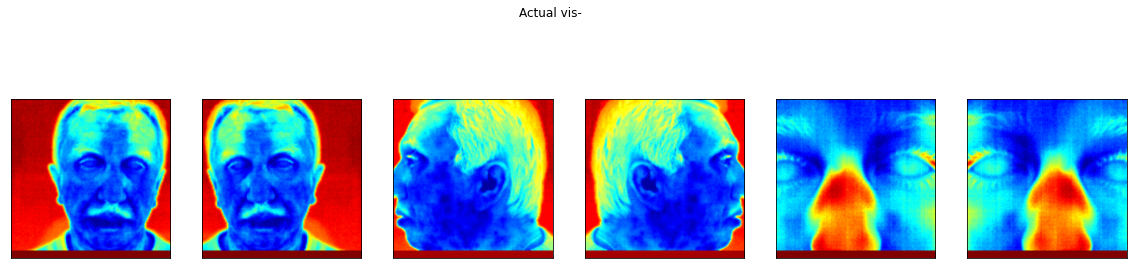

In [ ]:
col_idx = []
for i in range(len(val_aug_imgs)):  
  #col_idx.append(i)
  col_idx.append(i)
  #print(col_idx)
  #print(i%6)
  if (i+1)%6 ==0:
    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    fig.suptitle('Gradcam vis-')
    for a,j in enumerate(col_idx):
      #fig.suptitle('GradCAM Visualization', fontsize = 18)
      #plt.tight_layout()
      img  = np.expand_dims(val_aug_imgs[j], axis = 0)
      hm = make_gradcam_heatmap(img, logged_model, layer_name = None, pred_index=None)
      si = save_and_display_gradcam(img.reshape(256,256,3), hm, save = None, cam_path=None, alpha=0.7)
      fig.add_subplot(1,6,a+1)
      plt.imshow(si)
      plt.xlabel(f'Actual {val_aug_labels[j]},pred {logged_model(img)}')
      plt.xticks([])
      plt.yticks([])
      #col_idx.append(i)
    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    fig.suptitle('Actual vis-')
    for a,j in enumerate(col_idx):
      fig.add_subplot(1,6,a+1)
      plt.imshow(val_aug_imgs[j])
      plt.xticks([])
      plt.yticks([])
      #col_idx.append(i)
    col_idx = []
    
      #fig.add_subplot(,6,i+6+1)
  #plt.imshow(val_aug_imgs[i])
#plt.xlabel(f'actual-{val_aug_labels[i]}, predicted- {logged_model.predict(img)}')
plt.show()

## **Testing with intermediate activations**

In [ ]:
for i in range(6):
  if i%6!=0:
    

In [ ]:
layer_names = []
for layer in model.layers:
  layer_names.append(layer.name)

images_per_row = 16

In [ ]:
layer_names[:100]

In [ ]:
layer_outputs = [layer.output for layer in model.layers] # Extracts the outputs of the top 12 layers
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
img_tensor = x_test[0].reshape(1,256,256,3)

In [ ]:
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation

In [ ]:
grids = []

In [ ]:
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.imshow(display_grid)
    plt.show()
    #grids.append(display_grid)
    #plt.figure(figsize=(20,10))
    #plt.figure(figsize=(int(scale * display_grid.shape[1]),
    #                    int(scale * display_grid.shape[0])))
    #plt.title(layer_name)
    #plt.grid(False)
    #plt.imshow(display_grid, aspect='auto', cmap='viridis')


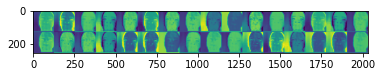

In [ ]:
plt.imshow(grids[6])